In [3]:
import pandas as pd
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point, Polygon
from scipy.spatial import Voronoi
import numpy as np
from geopandas.tools import sjoin



In [6]:

# Load stay point data
info = pd.read_csv(r"\\tsclient\D\Siyu Zhao\data\\Auckland region park\\infostop_with_specific_homelocation.csv")
info["geometry"] = info.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
stay_gdf = gpd.GeoDataFrame(info, geometry="geometry", crs="EPSG:4326").to_crs(epsg=3857)

# Load POIs
pois_path = Path(r"\\tsclient\D\Siyu Zhao\data\Auckland region park\Auckland-parks-poi.gpkg")
poi_gdf = gpd.read_file(pois_path).to_crs(epsg=3857)

poi_centroids = poi_gdf.geometry.centroid  
poi_coords = np.array([[geom.x, geom.y] for geom in poi_centroids])



In [7]:
vor = Voronoi(poi_coords)

def construct_voronoi_polygons(vor, poi_gdf):
    polygons = []
    for i, region_idx in enumerate(vor.point_region):
        vertices = vor.regions[region_idx]
        if -1 in vertices or len(vertices) == 0:
            polygons.append(None)
            continue
        polygon = Polygon([vor.vertices[i] for i in vertices])
        polygons.append(polygon)
    vor_gdf = gpd.GeoDataFrame(poi_gdf.copy(), geometry=polygons, crs="EPSG:3857")
    vor_gdf = vor_gdf[vor_gdf.geometry.notnull()]
    return vor_gdf

voronoi_gdf = construct_voronoi_polygons(vor, poi_gdf)


In [12]:
matched = gpd.sjoin(stay_gdf, voronoi_gdf, how='left', predicate='within')
poi_with_index = poi_gdf.reset_index() 
matched_result = matched.merge(
    poi_with_index,
    left_on='index_right',
    right_on='index',
    suffixes=('', '_poi')
)

In [13]:
matched_result['distance_stay_to_poi'] = matched_result.apply(
    lambda row: row['geometry'].distance(row['geometry_poi']), axis=1)

matched_result['home_geom'] = matched_result.apply(
    lambda row: Point(row['home_x'], row['home_y']), axis=1)

matched_result['distance_home_to_poi'] = matched_result.apply(
    lambda row: row['home_geom'].distance(row['geometry_poi']), axis=1)

c:\Users\Siyu\anaconda3\envs\mobility310\lib\site-packages\shapely\measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
c:\Users\Siyu\anaconda3\envs\mobility310\lib\site-packages\shapely\measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


In [14]:
print(matched_result.columns.tolist())

['stay_session_id', 'hashed_id', 'destination_id', 'start_ts', 'end_ts', 'point_count', 'lat_left', 'lon_left', 'duration_minutes', 'start_time', 'end_time', 'home_location_geom', 'home_x', 'home_y', 'geometry', 'index_right', 'id', 'timestamp', 'visible', 'version', 'tags', 'lon_right', 'changeset', 'lat_right', 'addr:city', 'addr:housenumber', 'addr:housename', 'addr:postcode', 'addr:street', 'email', 'name', 'opening_hours', 'operator', 'phone', 'ref', 'website', 'tourism', 'zoo', 'leisure', 'outdoor_seating', 'natural', 'amenity', 'bicycle_parking', 'fountain', 'internet_access', 'parking', 'source', 'start_date', 'wikipedia', 'shop', 'historic', 'memorial', 'access', 'foot', 'highway', 'lit', 'public_transport', 'railway', 'osm_type', 'wetland', 'building', 'building:levels', 'drinking_water', 'area', 'surface', 'aeroway', 'index', 'id_poi', 'timestamp_poi', 'visible_poi', 'version_poi', 'tags_poi', 'lon', 'changeset_poi', 'lat', 'addr:city_poi', 'addr:housenumber_poi', 'addr:hous

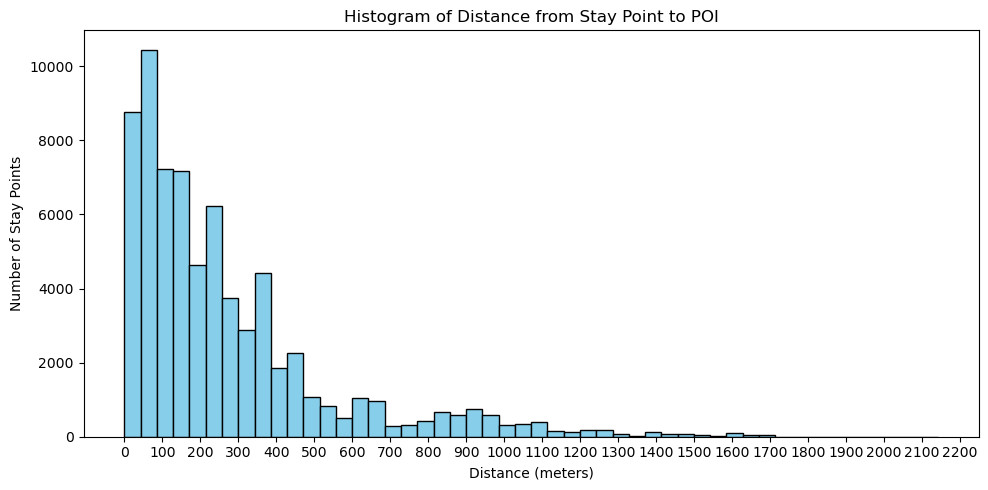

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))

plt.hist(matched_result['distance_stay_to_poi'], bins=50, color='skyblue', edgecolor='black')

max_dist = matched_result['distance_stay_to_poi'].max()
x_ticks = np.arange(0, max_dist + 100, 100)
plt.xticks(x_ticks)

plt.title("Histogram of Distance from Stay Point to POI")
plt.xlabel("Distance (meters)")
plt.ylabel("Number of Stay Points")

plt.tight_layout()
plt.show()

In [18]:
print(len(matched_result))
matched_result_100 = matched_result[matched_result['distance_stay_to_poi'] <= 100]
print(len(matched_result_100))

69987
21745


In [19]:
matched_result_100.to_csv("infostop_with_specific_homelocation_Voronoi_poi.csv", index=False)

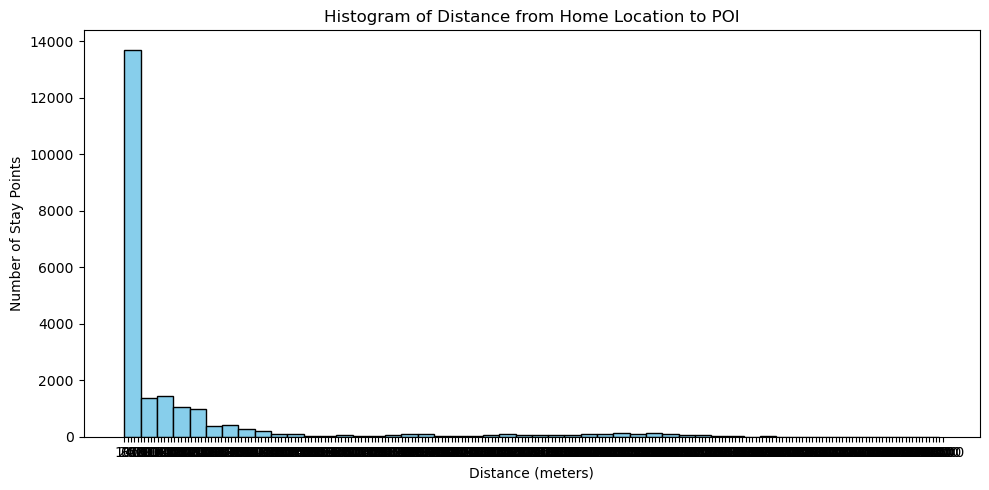

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))

plt.hist(matched_result_100['distance_home_to_poi'], bins=50, color='skyblue', edgecolor='black')

max_dist = matched_result_100['distance_home_to_poi'].max()
x_ticks = np.arange(0, max_dist + 100, 100)
plt.xticks(x_ticks)

plt.title("Histogram of Distance from Home Location to POI")
plt.xlabel("Distance (meters)")
plt.ylabel("Number of Stay Points")

plt.tight_layout()
plt.show()